The _objective_ of this notebook is to generate synthetic data which has the same variability as the historical data. In particular, we want the synthetic data to have the same covariance matrix as the historical data.
## Which variables should be included in this covariance matrix?
Some of the variables do not look Normal, and therefore the multivariate_normal method will always fail to make data that resembles the original distributions. Based on the histograms, Treasury Rate, home price index, mortgage rate, rent index, and vacancy rate seem more like uniform distributions (though home price index looks potentially like a bimodal Normal). I would exclude these variables from this data generation process. In the last cell, I generated new data without these variables included in the covariance matrix. The plots didn't change much, but at least it's easier to focus on the variables where you have a chance at modelling them as Normal.
### End goal -> Input needed
The output of this data generation should be return rates that can be multiplied by a portfolio value to give a return. Due to the time-dependency of some of the indexes, indexes are not always as valuable a output as the derivative of the indexes. We need the values that are going to show the most accurate/useful co-variances.
#### | Value | Index | Derivative | Which to use |


| Equity | S&P 500 Index | Return rate | Derivative

| Inflation | CPI | Inflation rate | CPI

| Bonds | Treasury 10-Year Yield | Rate of change | Index

| RE Appreciation | Home Price Index | Appreciation | Derivative

| RE Borrowing Cost | 30-Year Fixed Rate Mortgage | Rate of change | Index

| RE Income | Rent Index | Rate of change | Derivative

| RE Vacancy | Rental Vacancy Rate | Rate of change | Index


In [1]:
import numpy as np,pandas as pd
import matplotlib.pyplot as plt, seaborn as sn

In [2]:
SP500_quart_rate = pd.read_csv('SP500_quart_rate.csv',header=0,names=['DATE','SP500_Return'])
inflation_quart_rate = pd.read_csv('inflation_quart_rate.csv',header=0,names=['DATE','Inflation_Rate'])
treasury_bond_quart_rate = pd.read_csv('treasury_bond_quart_rate.csv',header=0,names=['DATE','Treasury_Yield','Treasury_Yield_Change'])
home_price_quart_rate = pd.read_csv('home_price_quart_rate.csv',header=0,names=['DATE','Home_Price_Index','Home_Price_Appreciation'])
mortgage_quart_rate = pd.read_csv('mortgage_quart_rate.csv',header=0,names=['DATE','Mortgage_Rate','Mortgage_Rate_Change'])
rent_quart_rate = pd.read_csv('rent_quart_rate.csv',header=0,names=['DATE','Rent_Index','Rent_Change'])
vacancy_quart_rate = pd.read_csv('vacancy_quart_rate.csv',header=0,names=['DATE','Vacancy_Rate','Vacancy_Rate_Change'])

merged_df = SP500_quart_rate.merge(inflation_quart_rate, how='inner',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(treasury_bond_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(home_price_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(mortgage_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(rent_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(vacancy_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df.drop(columns=['Treasury_Yield_Change','Home_Price_Index','Mortgage_Rate_Change','Rent_Index','Vacancy_Rate_Change'],inplace=True)
merged_df.describe()

,SP500_Return,Inflation_Rate,Treasury_Yield,Home_Price_Appreciation,Mortgage_Rate,Rent_Change,Vacancy_Rate
count,226.000000,226.000000,226.000000,189.000000,204.000000,226.000000,226.000000
mean,0.026977,0.009912,0.060548,0.012510,0.077726,0.009724,0.072704
std,0.070428,0.009530,0.030512,0.014110,0.032947,0.004587,0.015631
min,-0.223772,-0.039597,0.006506,-0.031516,0.027607,-0.000420,0.050000
25%,-0.012607,0.004827,0.037539,0.007493,0.050481,0.006799,0.058000
50%,0.031993,0.009247,0.059493,0.012348,0.074385,0.008859,0.073000
75%,0.069261,0.014915,0.077683,0.017778,0.095698,0.012232,0.082000
max,0.228656,0.043690,0.148384,0.067942,0.177357,0.026234,0.111000


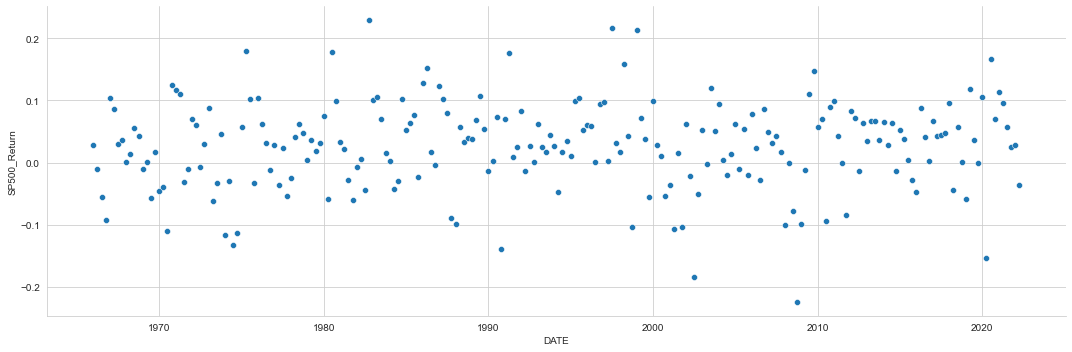

In [3]:
merged_df['DATE']= pd.to_datetime(merged_df['DATE'])
sn.set_style('whitegrid')
sn.relplot(data=merged_df, x='DATE', y='SP500_Return',
           aspect=3
          )
plt.show()

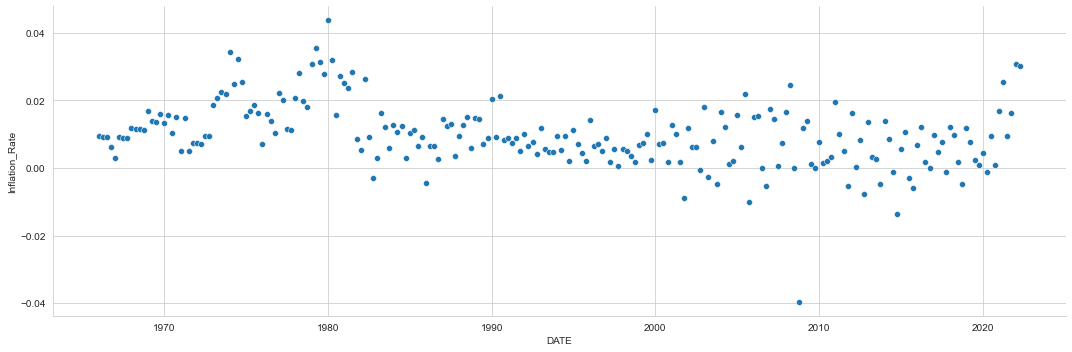

In [4]:
sn.relplot(data=merged_df, x='DATE', y='Inflation_Rate',
           aspect=3)
plt.show()

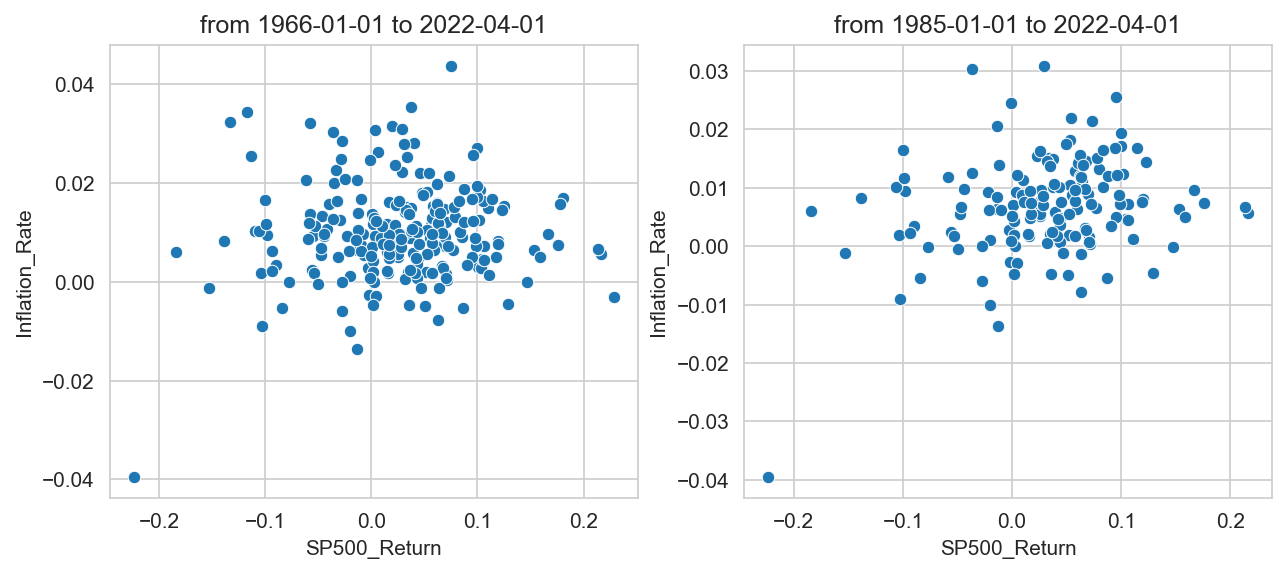

In [5]:
fig, ax= plt.subplots(1,2, figsize=(10,4), dpi=150)
sn.scatterplot(data=merged_df, x='SP500_Return',
            y='Inflation_Rate', ax=ax[0])
ax[0].set_title(f"from {merged_df['DATE'].min().date()} to {merged_df['DATE'].max().date()}")
start_date='1985-01-01'
sn.scatterplot(data=merged_df[merged_df['DATE']>=start_date], 
               x='SP500_Return', y='Inflation_Rate', ax=ax[1])
ax[1].set_title(f"from {start_date} to {merged_df['DATE'].max().date()}")
plt.show()

                         SP500_Return  Inflation_Rate  Treasury_Yield  \
SP500_Return                 0.004960        0.000036        0.000022   
Inflation_Rate               0.000036        0.000091        0.000110   
Treasury_Yield               0.000022        0.000110        0.000931   
Home_Price_Appreciation      0.000097        0.000040        0.000012   
Mortgage_Rate               -0.000015        0.000117        0.001043   
Rent_Change                 -0.000018        0.000017        0.000085   
Vacancy_Rate                -0.000022       -0.000061       -0.000238   

                         Home_Price_Appreciation  Mortgage_Rate  Rent_Change  \
SP500_Return                            0.000097      -0.000015    -0.000018   
Inflation_Rate                          0.000040       0.000117     0.000017   
Treasury_Yield                          0.000012       0.001043     0.000085   
Home_Price_Appreciation                 0.000199       0.000007     0.000019   
Mortgage_Rate  

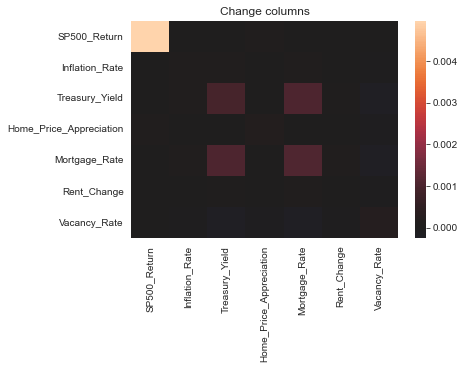

In [6]:
covMatrix = merged_df.cov()
print(covMatrix)
# sn.heatmap(covMatrix, vmin=-1, vmax=1, center=0)
sn.heatmap(covMatrix, center=0)
plt.title('Change columns')
plt.show()

Here we visualize the r values of correlations, which are scale invariant, unlike the covariances (and variances). From this heatmap, it's clear to see that S&P500 return is not correlated with any of the variables, execpt for home price appreciation (but only slightly). On the other hand, inflation rate is positively correlated with Treasury yield, home price appreciation, mortgage rate, and rent change. Inflation rate is also negatively correlated with vacancy rate. 

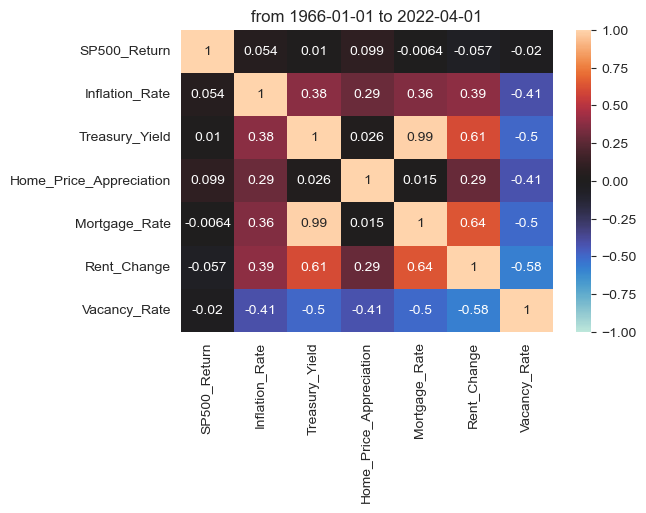

In [7]:
fig= plt.figure(dpi=100)
sn.heatmap(merged_df.corr(), center=0, vmin=-1, vmax=1, annot=True)
plt.title(f"from {merged_df['DATE'].min().date()} to {merged_df['DATE'].max().date()}")
plt.show()

The heatmap below shows the correlations for the same variables but only looking at the data after 1985. Most of the relationships change. In particular, the correlation between S&P return and inflation rate becomes quite clear. In fact, this is the strongest positive correlation between inflation rate and any other variable.
As I suspected, these correlations depend on the time period you're looking at. 

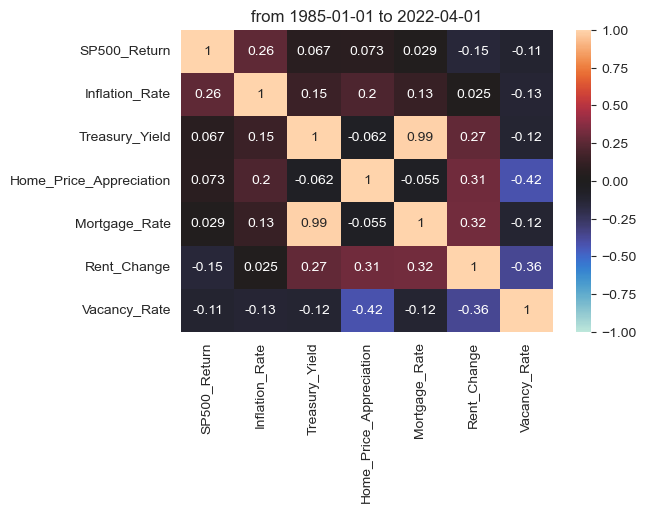

In [8]:
#shorter time frame for looking at correlation
fig= plt.figure(dpi=100)
sn.heatmap(merged_df[merged_df['DATE']>=start_date].corr(), 
           center=0, vmin=-1, vmax=1, annot=True)
plt.title(f"from {start_date} to {merged_df['DATE'].max().date()}")
plt.show()

In the heatmap below, you can see the covariance matrix after the individual variables are standardized. Notice that it is the same as the heatmap from corr().

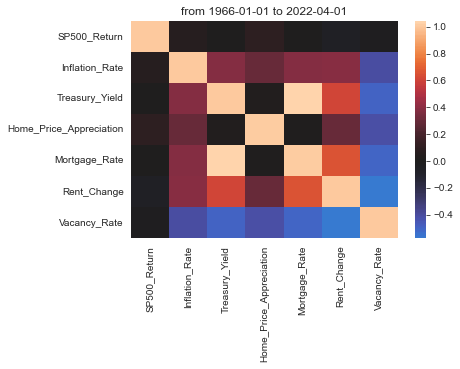

In [9]:
from sklearn.preprocessing import StandardScaler
#input data must be centered and scaled to unit variance
scaler= StandardScaler()
X= scaler.fit_transform(merged_df.drop(columns='DATE'))
#convert back to frame for convenience
X_df= pd.DataFrame(X, columns=merged_df.drop(columns='DATE').columns)
covMatrix = X_df.cov()
sn.heatmap(covMatrix , center=0)
plt.title(f"from {merged_df['DATE'].min().date()} to {merged_df['DATE'].max().date()}")
plt.show()

In [10]:
covMatrix = X_df.cov().values
mu = X_df.mean().values
print("Shape of covariance matrix",covMatrix.shape)
print("Shape of averages", mu.shape)
num_samples = 300
rng = np.random.default_rng()
gen_data = rng.multivariate_normal(mu, covMatrix, size=num_samples)
#change the scale of the generated data back to the original scale of the variables
gen_data = scaler.inverse_transform(gen_data)

Shape of covariance matrix (7, 7)
Shape of averages (7,)


C:\Users\frank\AppData\Local\Temp\ipykernel_23704\694289995.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  gen_data = rng.multivariate_normal(mu, covMatrix, size=num_samples)


## Problem: need to eliminate at least 1 variable from covariance matrix 
The warning from the previous cell is very important. It tells us that the covariance matrix is not positive-semidefinite. The method won't give us useful results until we fix our covariance matrix. If calculate the eigenvalues (below) we find that 1 of them is negative, which means we just need to eliminate 1 of our variables to get a positive-semidefinite matrix. Essentially, one of the variables is far too similar to the other ones and we need to eliminate it. 

After some trial and error, I found that either treasury yield or mortgage rate could be eliminated to make the covariance matrix positive-semidefinite. 

In [11]:
from numpy import linalg
eig_val, _ = linalg.eig(covMatrix)
print(eig_val)
if any(eig_val<0):
    print('The covariance matrix is not positive-semidefinite')
else:
    print('The covariance matrix is positive-semidefinite')   

[ 3.32332331  1.29782159  0.99051741 -0.03992719  0.66368374  0.38055306
  0.41649556]
The covariance matrix is not positive-semidefinite


In [12]:
col2use=merged_df.drop(columns=['DATE', 'Mortgage_Rate']).columns
#create frame with standardized columns
X_df= pd.DataFrame(scaler.fit_transform(merged_df[col2use]), 
                   columns=col2use)
covMatrix = X_df.cov()
eig_val, _= linalg.eig(covMatrix)
print(eig_val)
if any(eig_val<0):
    print('The covariance matrix is not positive-semidefinite')
else:
    print('The covariance matrix is positive-semidefinite')   

[2.62378496 1.10058429 0.91997993 0.65954019 0.3159188  0.40773321]
The covariance matrix is positive-semidefinite


In [13]:
col2use=merged_df.drop(columns=['DATE', 'Mortgage_Rate',
                               ]).columns
#create frame with standardized columns
scaler.fit(merged_df[col2use])
X_df= pd.DataFrame(scaler.transform(merged_df[col2use]), 
                   columns=col2use)
covMatrix = X_df.cov()
eig_val, _= linalg.eig(covMatrix)
print(eig_val)
if any(eig_val<0):
    print('The covariance matrix is not positive-semidefinite')
else:
    print('The covariance matrix is positive-semidefinite')   

[2.62378496 1.10058429 0.91997993 0.65954019 0.3159188  0.40773321]
The covariance matrix is positive-semidefinite


In [14]:
covMatrix = X_df.cov().values
mu = X_df.mean().values
print("Shape of covariance matrix",covMatrix.shape)
print("Shape of averages", mu.shape)
num_samples = 300
rng = np.random.default_rng()
gen_data = rng.multivariate_normal(mu, covMatrix, size=num_samples)
#change the scale of the generated data back to the original scale of the variables
generated_df= pd.DataFrame(scaler.inverse_transform(gen_data), 
                           columns=col2use)
generated_df.head()

Shape of covariance matrix (6, 6)
Shape of averages (6,)


,SP500_Return,Inflation_Rate,Treasury_Yield,Home_Price_Appreciation,Rent_Change,Vacancy_Rate
0,-0.048426,0.002299,0.050732,0.018355,0.016818,0.088786
1,0.106663,0.002233,0.052389,0.005496,0.008132,0.077063
2,0.102145,0.011960,0.037392,0.009254,0.005945,0.071795
3,0.061421,0.007861,0.042991,0.020092,-0.001837,0.079379
4,-0.076133,0.034295,0.091582,0.006032,0.013033,0.071487


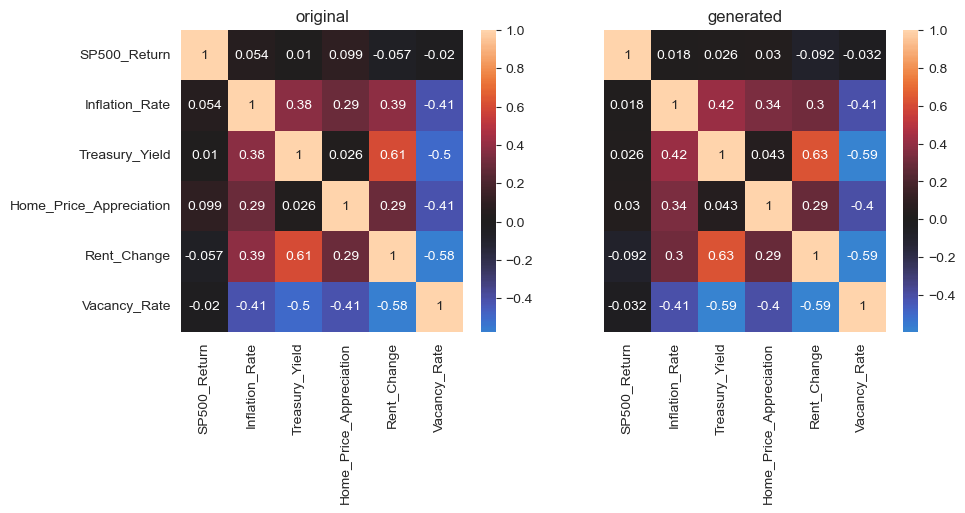

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=100, sharey=True)
sn.heatmap(merged_df[col2use].corr(), center=0, annot=True, ax=ax[0])
ax[0].set_title('original')
sn.heatmap(generated_df.corr(), center=0, annot=True, ax=ax[1])
ax[1].set_title('generated')
plt.show()

I correctly assigned the variable names to the columns of generated data by creating the dataframe generated_df. Not only did this dataframe allow us to conveniently calculate the heatmaps above, this dataframe also allows us to correctly see the histograms below. _Previosuly_, you left gen_data as an array and assumed that your for loop would correctly match the columns of gen_data to merged_df. But this assumption was flawed and that's why the plots made it look like the original data was vastly different from the generated data.

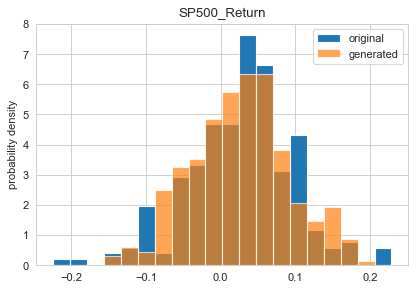

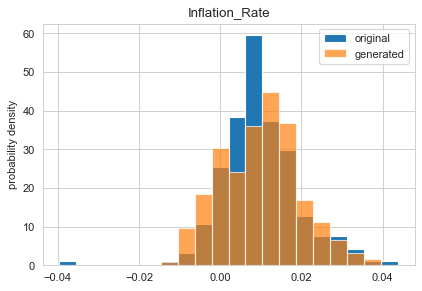

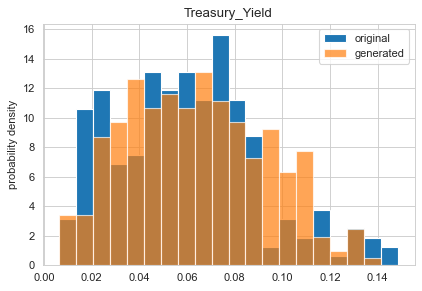

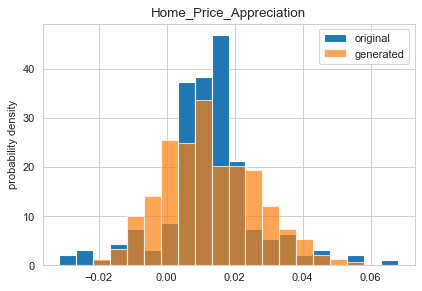

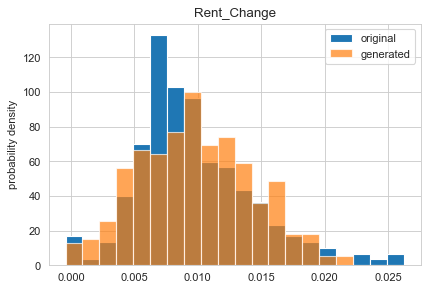

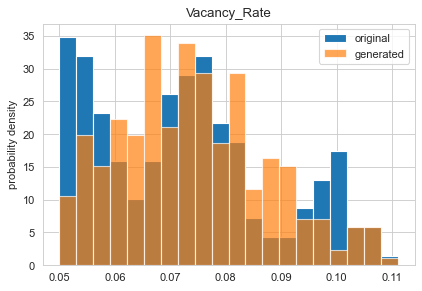

In [16]:
for col in col2use:
    plt.figure(dpi=80)
    plt.title(col)
    #use the same bins for both plots and normalize the density
    _, bins, _= plt.hist(merged_df[col], bins=20, label='original', density=True)
    plt.hist(generated_df[col],label='generated', bins=bins, density=True, alpha=0.7)
    plt.ylabel('probability density')
    plt.legend()